In [1]:
import os
os.chdir("..")
os.getcwd()

'/home/twoaday/research/deep-learning/visual-fashion-item-search'

In [2]:
%matplotlib inline
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageOps
import torch.utils.data as data
from keras.preprocessing import image
from tqdm import tqdm_notebook
from io import BytesIO
from torchvision import transforms
from torch.autograd import Variable
from utils.image_utils import scale_image

import glob
import requests
import numpy as np
import pandas as pd
import torch
from utils.composite_model_utils import load_extractor_model

CROP_SIZE = 224
DEFAULT_IMAGE_SIZE = 256
MODEL_PATH = '/home/twoaday/ai/models/fashion-vectorizer-converted.pth.tar'

Using TensorFlow backend.
2019-08-31 13:50:10,683 : INFO : Checking directories...
2019-08-31 13:50:10,684 : INFO : Directories are set.


In [3]:
extractor = load_extractor_model(MODEL_PATH)

In [4]:
path = '/run/media/twoaday/data-storag/data-sets/where2buyit/photos'
result = [y for x in os.walk(path) for y in glob.glob(os.path.join(x[0], '*.jpg'))]
df_data_set = []
for file in tqdm_notebook(result, desc = 'Parsing files'):
    s = file.split('/')
    name, product, category = s[-1].replace('.jpg', ''), s[-2], s[-3]
    df_data_set.append([name, product, category, file])
df_data_set = pd.DataFrame(df_data_set)
df_data_set.columns = ['name', 'product', 'category', 'file']

In [5]:
data_transform = transforms.Compose([
    transforms.Scale(CROP_SIZE),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

/usr/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [6]:
class SingleSampleLoader(data.Dataset):
    def __init__(self, img_path):
        self.img_path = img_path
    def __len__(self):
        return 1
    def __getitem__(self, index):
        with open(self.img_path, 'rb') as f:
            with Image.open(f) as img:
                img = img.convert('RGB')
                data = data_transform(img)
                return data 

In [7]:
def vectorize(img):
    single_loader = torch.utils.data.DataLoader(SingleSampleLoader(img), batch_size=1)
    data = list(single_loader)[0]
    data = Variable(data).cuda()
    deep_feat, color_feat = extractor(data)
    deep_feat = deep_feat[0].squeeze()
    color_feat = color_feat[0]
    return deep_feat, color_feat

In [8]:
def show_img(img_id):
    img = requests.get(photos_df.loc[photos_df.photo_id == img_id].url.values[0]).content
    img = Image.open(BytesIO(img))
    im = np.array(img, dtype=np.uint8)
    # Create figure and axes
    fig,ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)
    plt.show()

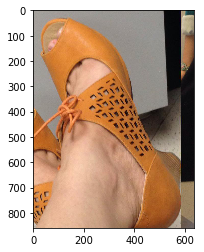

Anchor Image


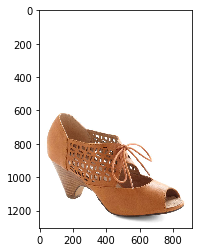

Deep Features Similarity: 0.670803964138031
Color Similarity: 0.45431336760520935
Weighted Similarity: 0.7162353008985519


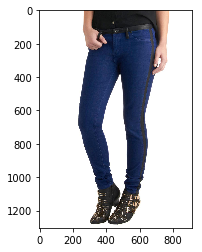

Deep Features Similarity: 0.49027496576309204
Color Similarity: -0.0829983800649643
Weighted Similarity: 0.4819751277565956


In [9]:
anchor_img = df_data_set.loc[df_data_set.name =='query'].sample(1)[['product', 'file', 'name']].values[0]
anchor_product = anchor_img[0]
anchor_name = anchor_img[2]
anchor_img = anchor_img[1]
anchor_features = vectorize(anchor_img)
anchor_deep_features, anchor_color_features = anchor_features[0] , anchor_features[1]

pos_img = df_data_set.loc[df_data_set['product'] == anchor_product]
pos_img = pos_img.loc[pos_img.name != anchor_name].sample(1).file.values[0]
pos_features = vectorize(pos_img)
pos_deep_features, pos_color_features = pos_features[0] , pos_features[1]

neg_img = df_data_set.loc[df_data_set['product'] != anchor_product].sample(1).file.values[0]
neg_features = vectorize(neg_img)
neg_deep_features, neg_color_features = neg_features[0] , neg_features[1]

plt.imshow(Image.open(anchor_img))
plt.show()
print('Anchor Image')

plt.imshow(Image.open(pos_img))
plt.show()
deep_similarity = 1. - cosine(anchor_deep_features, pos_deep_features)
color_similarity = 1. - cosine(anchor_color_features, pos_color_features)
weighted_similarity = deep_similarity + color_similarity * .1
print('Deep Features Similarity: {0}'.format(deep_similarity))
print('Color Similarity: {0}'.format(color_similarity))
print('Weighted Similarity: {0}'.format(weighted_similarity))

plt.imshow(Image.open(neg_img))
plt.show()

deep_similarity = 1. - cosine(anchor_deep_features, neg_deep_features)
color_similarity = 1. - cosine(anchor_color_features, neg_color_features)
weighted_similarity = deep_similarity + color_similarity * .1
print('Deep Features Similarity: {0}'.format(deep_similarity))
print('Color Similarity: {0}'.format(color_similarity))
print('Weighted Similarity: {0}'.format(weighted_similarity))

In [10]:
np.array_equal(pos_deep_features, neg_deep_features)

False

In [12]:
len(df_data_set.loc[df_data_set.name != 'query'])

5788